# Diabetes Onset Detection with Deep Learning
This is done following a tutorial from Eduonix.com. I also added contents the tutorial did not cover. For example, the issue with data imbalance and evaluating the model with a test set.

This dataset is originated from National Institute of Diabetes and Digestive and Kidney Diseases. The goal of this project is to use diagnostic measurements to predict whether an individual has diabetes. This dataset is taken from 
individuals who are female, at least 24-year-old, and of Pima-indian heritage.

This dataset is taken from kaggle:

https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix 
%matplotlib inline

Import keras and displaing backend as theano

In [3]:
import keras
keras.backend.backend()

'theano'

# Data exploration and pre-processing
Import data using pandas. Call the describe function to display a summary of the data. Note that measurements such as glucose and blood pressure cannot be zero, yet we are seeing minimum values of zero. That means some data is missing.

In [4]:
#import a diabetes dataset
data = pd.read_csv("Dataset/pima-indians-diabetes.csv")
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Also a good idea to visualize the distribution of each variable.

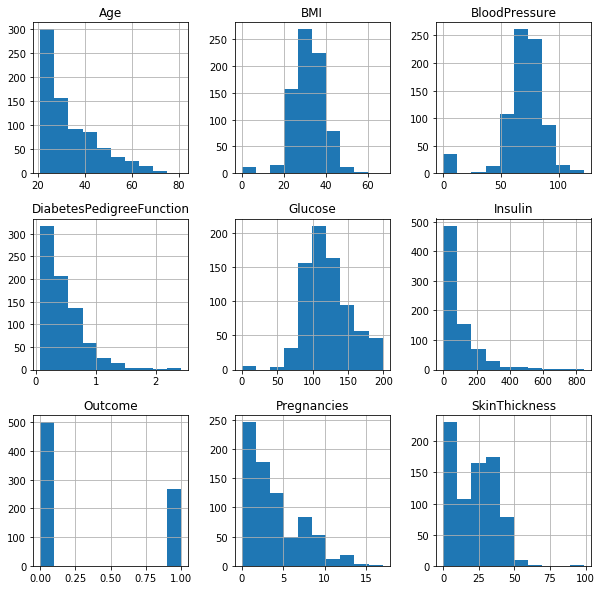

In [90]:
_=data.hist(figsize = (10,10))

Checking for correlations between features. Note the correlation between glucose and insulin and between BMI and skin thickness. Correlated data may introduce redundancies in the model. This may cause the surface of the loss function to have more local minima, interfering with the optimization algorithm. In this project, I chose to ignore this issue.

Also, you can see there are missing data in some of the plot. We should clean them up.

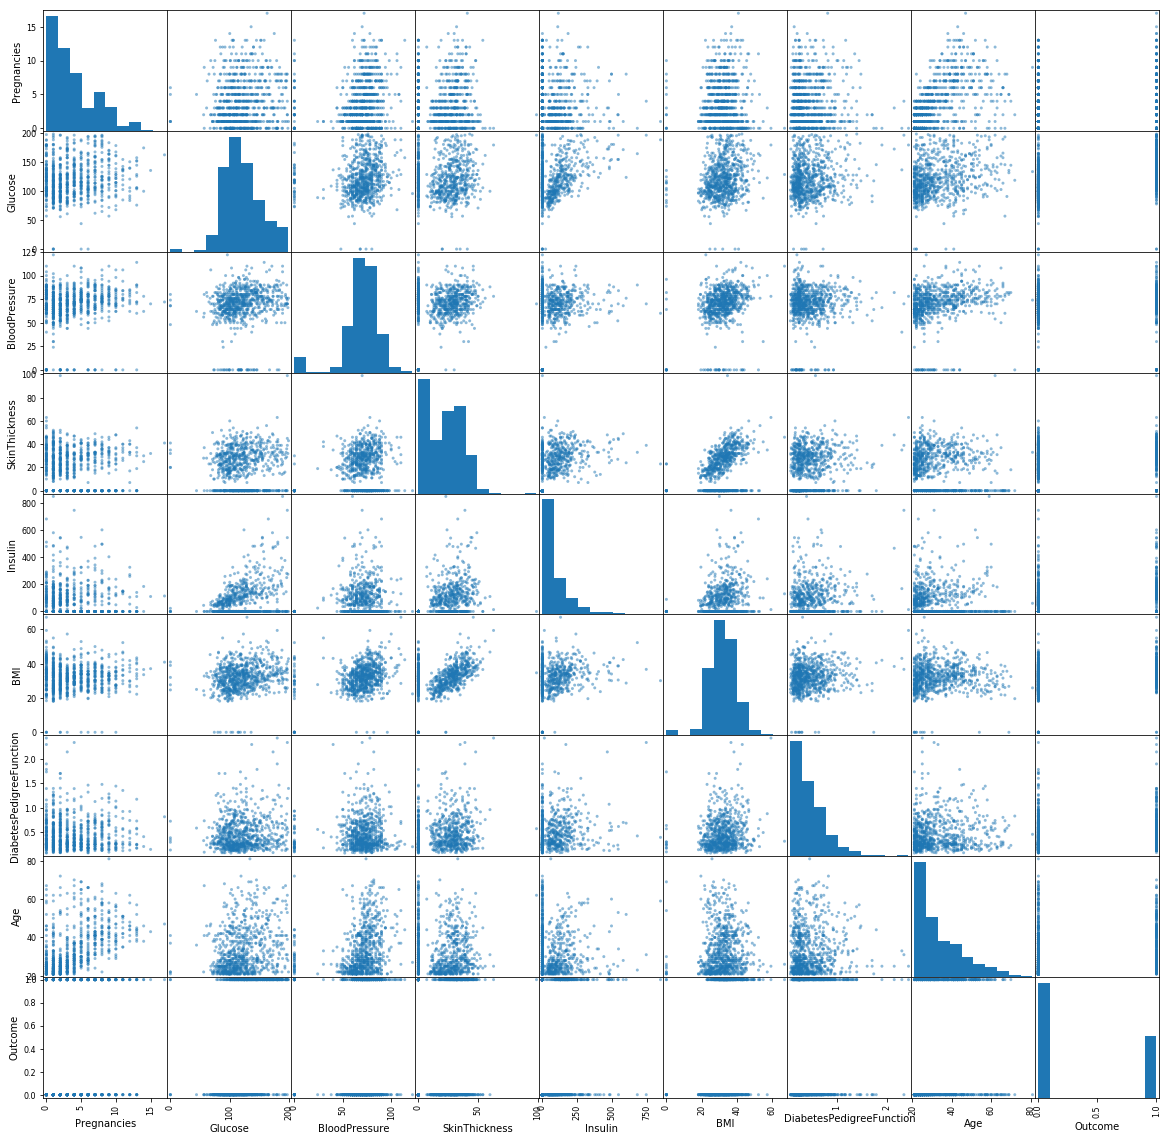

In [91]:
_=scatter_matrix(data,figsize=(20,20))

This is showing another way to visualize any correaltion in the data. (More blue: less correlation; more yellow: more correlation.)

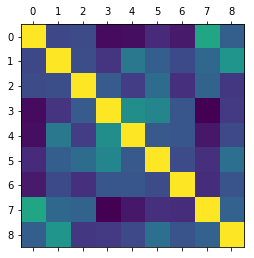

In [92]:
plt.matshow(data.corr())
plt.show()

Since the data in any of the following column cannot be zero, I am replacing any zero values with np.nan.

In [5]:
col_replace = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in col_replace:
    data[col].replace(0,np.nan,inplace=True)

There are several ways to deal with missing data. One way is to replace the missing data with the mean or mode of the column. However, I have tried this with my model and it did not give me a good result. Another way is to remove any row with a missing value. This reduces the chance of introducing artifacts but will throw away a lot of data. This is what's left in the data set: ~250 negative and ~125 positive. 

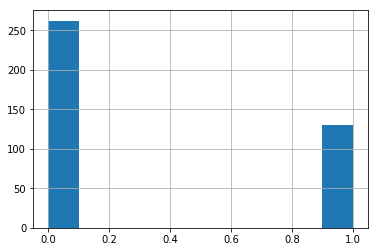

In [6]:
data.dropna(inplace=True)
data['Outcome'].hist()

We can visualize the matrix again. Note that the zero values are gone.

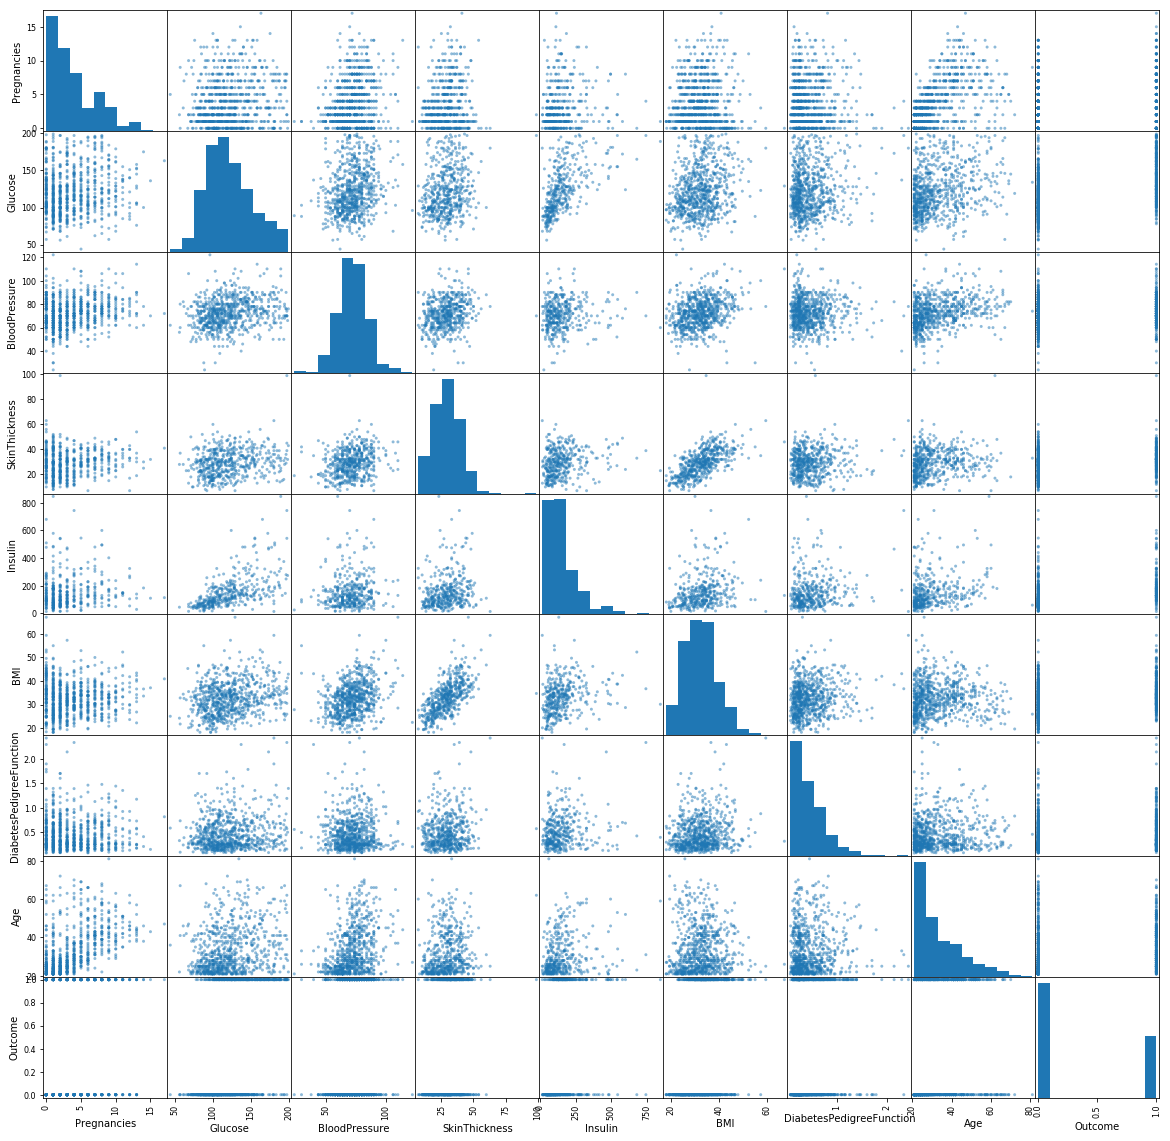

In [94]:
_=scatter_matrix(data,figsize=(20,20))

Because there are much more negative cases than positive cases, this may cause the model to predict negative cases more often and still achieve a higher accuracy. This is not good. So it is necessary to resample the negative data and throw away the extra data. This method is quite wasteful, but we can still use the data in our test set.

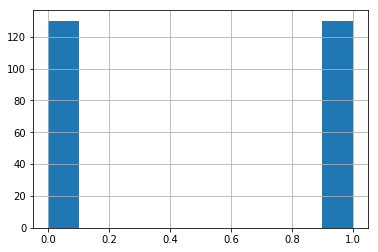

In [35]:
pos = data[data['Outcome']==1]
neg = data[data['Outcome']==0]
resampled = pd.concat([pos,neg.sample(len(pos))])
#the classes are now balanced
resampled['Outcome'].hist()

Store the data not included in the resampling as unused_data for use in testing

In [36]:
import copy
data_c = copy.copy(data)
unused_data = data_c.drop(resampled.index)

Now it's time to split the data up into features and target. A describe of the data shows that the data needs to be scaled by standardizing.

In [37]:
sel_col = ['Glucose','BloodPressure','SkinThickness',
          'Insulin','BMI','Pregnancies',
          'DiabetesPedigreeFunction','Age']
d_X = resampled[sel_col].astype(float)
y = resampled['Outcome']
d_X.describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DiabetesPedigreeFunction,Age
count,260.000000,260.000000,260.000000,260.000000,260.00000,260.000000,260.000000,260.000000
mean,128.676923,71.200000,30.146154,174.961538,33.90000,3.623077,0.548369,32.207692
std,31.901929,12.870546,10.352931,124.109642,7.13939,3.552726,0.360679,10.788021
min,56.000000,30.000000,7.000000,14.000000,18.20000,0.000000,0.088000,21.000000
25%,103.750000,64.000000,22.750000,93.500000,29.20000,1.000000,0.288500,24.000000
50%,126.000000,70.000000,30.000000,145.500000,33.90000,2.000000,0.466500,28.000000
75%,151.250000,80.000000,37.000000,211.250000,37.42500,6.000000,0.702750,39.000000
max,198.000000,110.000000,63.000000,846.000000,67.10000,17.000000,2.420000,81.000000


After scaling the data, all the features have a mean closed to zero and a stardard deviation close to 1. It is important when scaling the data, it is necessary to use the mean and std of the entire dataset to transform any sub-dataset.

In [38]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(data[sel_col].astype(float))
X = ss.transform(d_X)
#also scale the unused data
data_X = ss.transform(unused_data[sel_col].astype(float))
data_y = unused_data['Outcome']
#display scaled data
pd.DataFrame(X,columns=sel_col).describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DiabetesPedigreeFunction,Age
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.196272,0.043007,0.095282,0.159284,0.115944,0.100413,0.073391,0.131815
std,1.035058,1.031282,0.985712,1.045662,1.017197,1.107691,1.045302,1.058920
min,-2.161731,-3.258237,-2.108484,-1.196867,-2.120941,-1.029213,-1.260831,-0.968299
25%,-0.612482,-0.533909,-0.608912,-0.527055,-0.553697,-0.717427,-0.679750,-0.673828
50%,0.109419,-0.053146,0.081366,-0.088939,0.115944,-0.405640,-0.163879,-0.281200
75%,0.928655,0.748127,0.747843,0.465025,0.618175,0.841505,0.520810,0.798527
max,2.445459,3.151946,3.223325,5.812990,4.846172,4.271153,5.497667,4.921123


Now we are ready to train a neural network.

- We need to split the data into testing and training set, since the dataset is quite small. It's good to only keep a small fraction as the testing set

- Define a build funtion in which we will use the keras APIs to define our neural network. The build func also allow runtime changes of hyper-parameters such as learning rate or the number of neurons.

In [39]:
#import machine learning libraries
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

#split into testing and training set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
#define random seed
seed = 6
#start defining the model
def create_model(learn_rate,activation,init,neuron1,neuron2):
    #create model
    model = Sequential() #sequential meaning one layer goes after another
    #Dense meaning the layers are fully connected
    model.add(Dense(neuron1, input_dim=8, kernel_initializer=init,activation=activation))
    model.add(Dense(neuron2, input_dim=neuron1, kernel_initializer=init,activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    #compile the model
    adam = Adam(lr=learn_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    return model

#create the model. The hyper-parameters such as batch_size, epoch, and dropout_rate will be passed
#into this function. Verbose defines how much print out there will be during the training.
model = KerasClassifier(build_fn = create_model, verbose = 0)

#Define the search parameters in lists
batch_size = [10,20,40]
epochs = [10,50]
learn_rate = [0.1,0.01,0.001]
dropout_rate = [0.0,0.1,0.2]
activation = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']
neuron1 = [4,8,16]
neuron2 = [2,4,8]
#Make a dictionary of search parameters
param_distributions = dict(batch_size=batch_size,epochs=epochs,
                  learn_rate=learn_rate,dropout_rate=dropout_rate,
                  activation=activation,init=init,neuron1=neuron1,neuron2=neuron2)
#Build and fit the RandomizedSearchCV. I have used GridSeachCV before but since the algorithm is 
#going through every permutation possible, it is very expansive computationally. RandomizedSearchCV
#only go through the permutation randomly, it gives an estimate of what the best parameters should be.

#KFold is a cross validation method to estimate the accuracy of the model without using the test set.
#Here I am setting the random_state to a seed so that it will split the same way every training. 
search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,cv=KFold(random_state=seed), verbose=5)
search_results = search.fit(pd.DataFrame(X_train),y_train)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] neuron2=2, neuron1=16, learn_rate=0.1, init=normal, epochs=10, dropout_rate=0.2, batch_size=40, activation=linear 
[CV]  neuron2=2, neuron1=16, learn_rate=0.1, init=normal, epochs=10, dropout_rate=0.2, batch_size=40, activation=linear, score=0.7307692338258792, total=   5.2s
[CV] neuron2=2, neuron1=16, learn_rate=0.1, init=normal, epochs=10, dropout_rate=0.2, batch_size=40, activation=linear 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  neuron2=2, neuron1=16, learn_rate=0.1, init=normal, epochs=10, dropout_rate=0.2, batch_size=40, activation=linear, score=0.6538461645444235, total=   4.7s
[CV] neuron2=2, neuron1=16, learn_rate=0.1, init=normal, epochs=10, dropout_rate=0.2, batch_size=40, activation=linear 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


[CV]  neuron2=2, neuron1=16, learn_rate=0.1, init=normal, epochs=10, dropout_rate=0.2, batch_size=40, activation=linear, score=0.8076923076923077, total=   4.3s
[CV] neuron2=8, neuron1=16, learn_rate=0.01, init=zero, epochs=10, dropout_rate=0.0, batch_size=20, activation=relu 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s


[CV]  neuron2=8, neuron1=16, learn_rate=0.01, init=zero, epochs=10, dropout_rate=0.0, batch_size=20, activation=relu, score=0.4358974358974359, total=   6.1s
[CV] neuron2=8, neuron1=16, learn_rate=0.01, init=zero, epochs=10, dropout_rate=0.0, batch_size=20, activation=relu 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.8s remaining:    0.0s


[CV]  neuron2=8, neuron1=16, learn_rate=0.01, init=zero, epochs=10, dropout_rate=0.0, batch_size=20, activation=relu, score=0.4743589758872986, total=   6.1s
[CV] neuron2=8, neuron1=16, learn_rate=0.01, init=zero, epochs=10, dropout_rate=0.0, batch_size=20, activation=relu 
[CV]  neuron2=8, neuron1=16, learn_rate=0.01, init=zero, epochs=10, dropout_rate=0.0, batch_size=20, activation=relu, score=0.4999999923583789, total=   7.8s
[CV] neuron2=8, neuron1=16, learn_rate=0.01, init=uniform, epochs=50, dropout_rate=0.2, batch_size=40, activation=tanh 
[CV]  neuron2=8, neuron1=16, learn_rate=0.01, init=uniform, epochs=50, dropout_rate=0.2, batch_size=40, activation=tanh, score=0.7307692338258792, total=  15.5s
[CV] neuron2=8, neuron1=16, learn_rate=0.01, init=uniform, epochs=50, dropout_rate=0.2, batch_size=40, activation=tanh 
[CV]  neuron2=8, neuron1=16, learn_rate=0.01, init=uniform, epochs=50, dropout_rate=0.2, batch_size=40, activation=tanh, score=0.6666666651383425, total=  16.6s
[CV] 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.1min finished


In [40]:
print("The best accuracy: {}, Using parameters: {}".format(search_results.best_score_,search_results.best_params_))

The best accuracy: 0.735042743703239, Using parameters: {'neuron2': 8, 'neuron1': 16, 'learn_rate': 0.01, 'init': 'normal', 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 20, 'activation': 'linear'}


# Scoring of the model performance.

Precision = True positive / (True positive + False positive)
Recall = True positive / (True positive + False negative)

Precision is saying how many of the predicted class turn out to be correct. (Can indicate overprediction)
Recall is saying how many of the actual class is predicted correctly. (can indicate underprediction)

- Performance on the test set. 

- Performance on the training set.

- Performance on the unused data. Since there is not positive data, the positive class scorings are zeros.

All of them have acceptable scores, so I would say this is a success.

In [45]:
from sklearn.metrics import classification_report, accuracy_score
print('Scoring the test set')
print(accuracy_score(search.predict(X_test),y_test))
print(classification_report(search.predict(X_test),y_test))
print(pd.Series(y_test).value_counts())
print('Scoring the training set')
print(accuracy_score(search.predict(X_train),y_train))
print(classification_report(search.predict(X_train),y_train))
print('Scoring the unused dataset')
print(accuracy_score(search.predict(data_X),data_y))
print(classification_report(search.predict(data_X),data_y))

Scoring the test set
0.8076923076923077
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.81      0.87      0.84        15

   micro avg       0.81      0.81      0.81        26
   macro avg       0.81      0.80      0.80        26
weighted avg       0.81      0.81      0.81        26

1    16
0    10
Name: Outcome, dtype: int64
Scoring the training set
0.7478632478632479
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       121
           1       0.74      0.74      0.74       113

   micro avg       0.75      0.75      0.75       234
   macro avg       0.75      0.75      0.75       234
weighted avg       0.75      0.75      0.75       234

Scoring the unused dataset
0.8181818181818182
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       108
           1       0.00      0.00      0.00        24

   micro